In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
import sys
import pathlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import json



%matplotlib inline  

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS_1_2.csv.gz")

# Load expression data 
with open("outputs/HeLa_SABER_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# subset the profiles to only expressed genes
gene_list = express['expressed_genes']
df_genes = df_guide[(df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(gene_list))]

# Create a dattaframe of only features without metadata
feature_df = df_genes.drop(['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'],axis = 1).reset_index(drop=True)
feature_df

,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,Cells_AreaShape_CentralMoment_2_3,...,Nuclei_Texture_SumEntropy_Syto9_10_03_256,Nuclei_Texture_SumEntropy_btubulin_10_01_256,Nuclei_Texture_SumVariance_Calnexin_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
0,-0.052235,-0.158375,0.013107,-0.100975,-0.163630,0.189520,0.285264,0.125879,-0.278317,-0.237865,...,-0.301305,-0.026015,-0.422110,-0.436075,-0.328195,-0.294850,0.181285,0.130507,0.198450,-0.292855
1,-0.258900,-0.459740,-0.272072,-0.060422,-0.397970,0.081770,-0.033692,0.056625,0.040295,0.111003,...,-0.491365,-0.659530,-0.478125,-0.226015,-0.372045,-0.458385,-0.075922,0.011385,0.051656,-0.447315
2,-0.132880,-0.252800,0.099935,0.130246,0.048945,-0.025845,-0.033111,0.097072,0.127338,0.026097,...,-0.579905,-0.419715,-0.291180,-0.236695,-0.223783,-0.305315,0.158725,0.008738,0.000045,-0.240930
3,0.023685,0.187520,0.034279,-0.255330,0.678388,-0.058525,-0.052645,-0.016378,0.434255,0.013650,...,-0.199930,-0.628520,-0.509130,-0.422055,-0.499170,-0.543055,-0.082475,0.050340,0.046263,-0.523410
4,0.246670,-0.368480,-0.168987,0.040285,-0.057675,0.577885,0.510590,0.619805,-0.120377,0.304360,...,-0.472220,0.350025,-0.285700,-0.310835,-0.825055,-0.658360,-0.260640,-0.189415,0.186295,-0.276285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,0.216305,-1.650260,-0.452646,0.291878,-0.873555,-0.078410,0.338770,-0.311883,-0.441927,-0.261302,...,0.566295,-0.141973,-0.635665,-0.492905,0.227515,0.527475,-0.110906,-0.398940,-0.108978,0.252682
2192,0.615510,1.359005,-0.274150,0.194880,1.528650,0.971260,0.614760,0.810910,0.431500,0.366010,...,2.681250,3.063050,1.016290,2.749200,3.414700,3.464550,-0.041155,2.119250,0.515310,3.395000
2193,-1.578650,0.972215,-0.775777,0.460705,0.249273,-0.230249,0.441185,-0.237964,-0.283025,0.053291,...,0.306400,-0.763880,-0.206755,0.385165,0.243965,0.348820,0.059860,0.478465,0.302830,0.352051
2194,0.138300,0.781670,-0.214375,0.894380,0.903405,-0.319950,-0.477800,-0.248910,-0.151220,-0.176194,...,-0.451345,0.119835,-0.164690,0.250930,-0.373515,-0.202849,0.027470,0.003737,-0.131688,-0.312420


In [4]:
n_features = min(len(feature_df.columns),len(feature_df))
model = PCA(n_components = n_features).fit(feature_df)
X_pc = model.transform(feature_df)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
initial_feature_names = list(feature_df.columns)

# Extract the composition of each principal component coming from the PCA transformation and catalog it in the most_important dictionary 
most_important = {}
for i in range(n_pcs):
    temp = np.abs(model.components_[i]).argsort()
    temp = temp[::-1] 
    most_important['PC{}'.format(i+1)] = [{initial_feature_names[temp[j]]: np.abs(model.components_[i])[temp[j]]} for j in range(n_features)]
    

len(most_important)

2196

In [5]:
# For each feature amd per each PC use the "percentage of variance explained by each of the selected components" (from explained_variance_ratio_) 
# in additon to .component factor (This value tells us 'how much' the feature influences the PC) to calculate the "feature importance"

ratios = model.explained_variance_ratio_
feature_dic = {}
for count, key in enumerate(most_important.keys()):
    for c, k in enumerate(most_important[key]):
        value = list(k.values())[0] * ratios[count]
        if list(k.keys())[0] in feature_dic.keys():
            feature_dic[list(k.keys())[0]].append(value)
        else:
            feature_dic[list(k.keys())[0]] = [value]
len(feature_dic)

3011

In [7]:
# Sum up all the feature importance scores from each PC to calculate a final feature importance score
feature_scores = {}
added_values = 0
for feature in feature_dic.keys():
    feature_scores[feature] = sum(feature_dic[feature])
    added_values += sum(feature_dic[feature])

feature_scores_df = pd.DataFrame.from_dict(feature_scores, orient='index')
feature_scores_df = feature_scores_df.reset_index().rename({"index":"feature",0:"score"},axis=1)
feature_scores_df.to_csv(os.path.join(output_folder,'Hela_SABER_pilot_SABER_1_2_PCA_derived_feature_importance_scores.csv'),index = False)
feature_scores_df

,feature,score
0,Cytoplasm_Correlation_Overlap_COXIV_DNA,0.013113
1,Cells_Texture_Contrast_Syto9_5_02_256,0.013711
2,Nuclei_Correlation_Overlap_Cycle01_DAPI_Phallo...,0.012422
3,Cells_Correlation_Overlap_DNA_Phalloidin,0.014309
4,Cells_Correlation_Correlation_PRSP6_Phalloidin,0.012540
...,...,...
3006,Cytoplasm_AreaShape_CentralMoment_2_1,0.005074
3007,Cells_AreaShape_NormalizedMoment_2_3,0.005121
3008,Nuclei_AreaShape_NormalizedMoment_2_3,0.004877
3009,Cells_AreaShape_NormalizedMoment_2_1,0.004889


In [15]:
# Calculate the PCA derived importnce for each channel by adding all the feature scores from that channel
channels = ['COXIV','GM130','Calnexin','DNA','Phalloidin','Catalase','btubulin','NfKb','LAMP1','PRSP6','Syto9','TDP43','G3BP1','WGA','ConA']
channel_score_dic = {}
for channel in channels:
    temp_score = feature_scores_df[feature_scores_df.feature.str.contains(channel, case=False)].score.sum()
    channel_score_dic[channel] = temp_score
channel_score_dic

{'COXIV': 3.38087843573735,
 'GM130': 3.0253164603807776,
 'Calnexin': 3.053152764383575,
 'DNA': 4.132616587160007,
 'Phalloidin': 3.1422690339460355,
 'Catalase': 2.421098231933819,
 'btubulin': 2.9225057287770313,
 'NfKb': 2.7120272583382423,
 'LAMP1': 2.355969146686756,
 'PRSP6': 3.2617367935247734,
 'Syto9': 4.334743951469687,
 'TDP43': 3.74450896432302,
 'G3BP1': 2.4404394353186283,
 'WGA': 2.8885446107233603,
 'ConA': 3.6758372847124807}

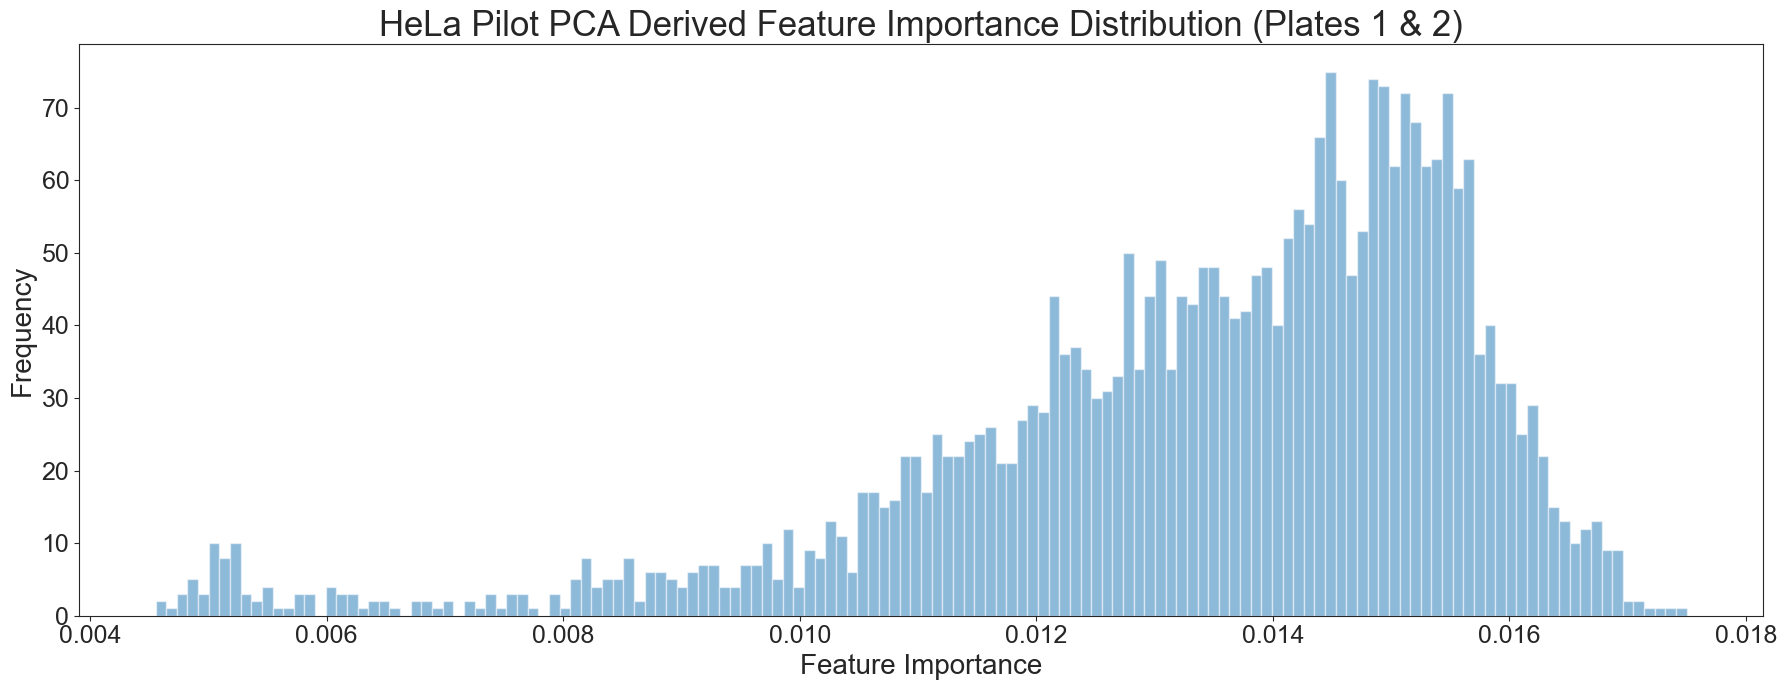

In [16]:
fig, ax = plt.subplots(figsize=(18,7))
sns.reset_defaults()
sns.set_style("ticks")
feature_scores_df.plot.hist(bins=int(576/4),color='tab:blue',alpha=0.5,ax=ax)


ax.set_title('HeLa Pilot PCA Derived Feature Importance Distribution (Plates 1 & 2)', fontdict= {'fontsize':25})
ax.set_xlabel('Feature Importance', fontdict= {'fontsize':20})
plt.xticks(fontsize=18)
ax.set_ylabel('Frequency', fontdict= {'fontsize':20})
plt.yticks(fontsize=18)
ax.get_legend().remove()
plt.tight_layout()
fig.savefig(os.path.join(output_folder,'figure_panels','HeLa_SABER_PCA_derived_feature_importance_distribution.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

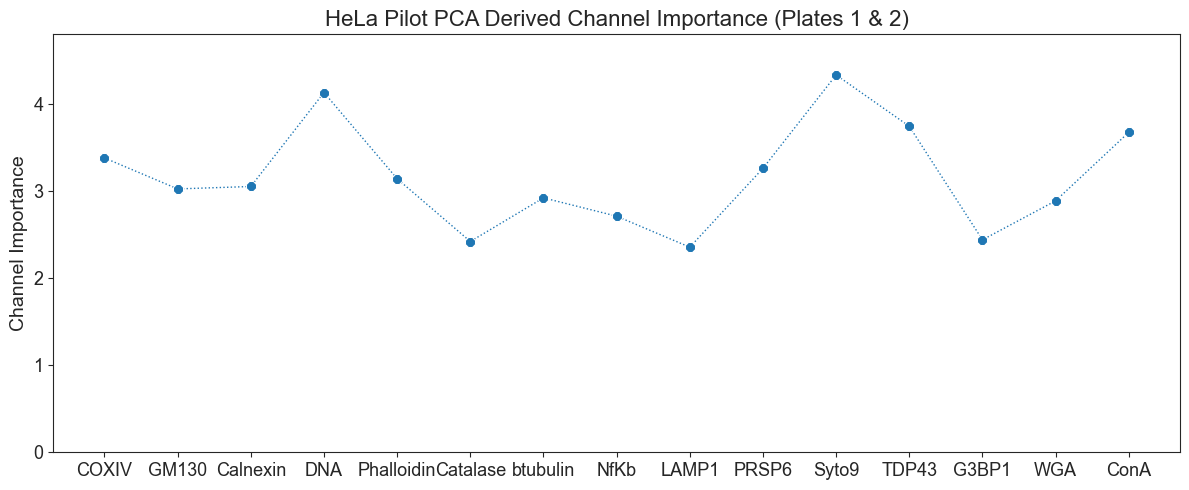

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.reset_defaults()
sns.set_style("ticks")


a = list(channel_score_dic.keys())
b = list(channel_score_dic.values())
sns.lineplot(x=a,
             y=b,
             color='tab:blue',
             marker='8',
             markersize=8,
             linestyle=':',
             linewidth = 1,
             ax=ax)
ax.set_title('HeLa Pilot PCA Derived Channel Importance (Plates 1 & 2)', fontdict= {'fontsize':16})
#ax.set_xlabel('Feature Importance', fontdict= {'fontsize':16})
plt.xticks(fontsize=13)
ax.set_ylabel('Channel Importance', fontdict= {'fontsize':14})
plt.yticks(fontsize=13)
ax.set_ylim([0, 4.8])
plt.tight_layout()
fig.savefig(os.path.join(output_folder,'figure_panels','HeLa_SABER_PCA_derived_channel_importance.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()